# Genre Prediction Using The Free Music Archive

The rules for how music is organized can seem arbitrary. What causes one song to fall into one category versus another may change from grader to grader. Marketers may define a genre depending on what customers wish to purchase as a group, while musicologists may decide based on rhythmic features, and untrained fans may define genre based on the bands that sound the most similar to their favorites. But what is the feature content available for machine learning approaches to define these groups autonomously? 

In this analysis we use the Free Music Archive (FMA) to attempt genre classification of three genres (Rock, Electronic, and Experimental) using categorical and quantitative features made available from Librosa and EchoNest (now Spotify). 

In [33]:
import sqlite3
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

The FMA is organized around tracks as the central feature. Each track has information about the artist and the song represented. 

In [34]:
tracks = pd.read_csv('../data/raw/fma_metadata/tracks.csv', index_col=0, header=[0,1])
print(tracks.shape)

(106574, 52)


## EDA and Data Integrity

Before diving into the data set, we can perform some general checks on data integrity and get an idea which fields are the most incomplete, and therefore will be the most problematic for machine learning approaches.

### Missing Columns

We first take a look at data completeness, assessing which columns are missing the most information.

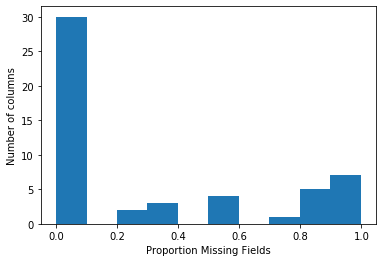

In [35]:
# Get proportion of missing fields by column
n_null = tracks.isnull().sum() / len(tracks)
plt.hist(n_null)
plt.xlabel('Proportion Missing Fields')
plt.ylabel('Number of columns')
plt.show()

We can see that there are a number of fields missing 20% or more of their data. We can inspect the dataframe to find what specific columns are represented here.

In [36]:
high_miss = n_null[n_null > 0.20]
print(high_miss)

album   date_released        0.340421
        engineer             0.856485
        information          0.219800
        producer             0.830540
artist  active_year_begin    0.786899
        active_year_end      0.949566
        associated_labels    0.866093
        bio                  0.332332
        latitude             0.582037
        location             0.341209
        longitude            0.582037
        members              0.560409
        related_projects     0.876593
        website              0.256329
        wikipedia_page       0.947633
track   composer             0.965564
        date_recorded        0.942209
        genre_top            0.534614
        information          0.977959
        language_code        0.859028
        lyricist             0.997082
        publisher            0.988149
dtype: float64


The most highly missing columns are specific string fields like `lyricist` and `publisher` or `bio`. However we do find some problematic columns that may complicate our analysis, including `genre_top`, which gives the top genre for the specified track. We can also see that roughly half of tracks are missing `longitude` and `latitude` data, which will impact geographical analysis.

### Row-wise Missingness

We also wish to investigate the row-wise missingness to assess whether the missing fields are grouped within the same track. For example, it is possible that there is a subset of 50% of tracks missing 90% of fields. This will impact our data cleaning strategy.

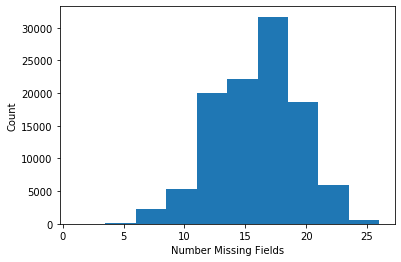

In [37]:
isna_sum = lambda row: row.isna().sum()
track_row_na = tracks.apply(isna_sum, axis=1)
plt.hist(track_row_na)
plt.xlabel('Number Missing Fields')
plt.ylabel('Count')
plt.show()

From the histogram, we can see that most tracks are missing several fields. In fact, of the 52 fields included in the dataset, a mean of roughly 17 seem to be missing for any given track. The roughly normal distribution of data tells us that there does not appear to be a single group of fields missing in a large number of tracks. We can therefore conclude that from the identified 'high missingness' tracks above, a more or less random subset of those fields can be missing for any given track.

To further verify that this is the case, we can look at broad correlation between the data, we can consider the phi coefficient (also known as the matthews coefficient), a measure of correlation between binary variables. In effect, if two fields tend to be missing at the same time, they will have a high phi coefficient. The python package `sklearn` provides an implementation of the phi coefficient.

In [38]:
# Create dataframe representation with na values flagged as True
na_grid = tracks.applymap(pd.isna)

# Create dataframe with column labels
from itertools import permutations
combos = list(permutations(tracks.columns, 2))
corr_df = pd.DataFrame(combos)

# Use column labels to coordinate application of matthews_corrcoef
from sklearn.metrics import matthews_corrcoef
corr_vals = []
for r in range(len(corr_df)):
    fields = corr_df.iloc[r]
    field1 = fields[0]
    field2 = fields[1]
    corr_val = matthews_corrcoef(na_grid[field1], na_grid[field2])
    corr_vals.append(corr_val)
corr_df['corr_val'] = corr_vals

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [39]:
corr_df.sort_values('corr_val', ascending=False)[:15]

,0,1,corr_val
1194,"(artist, longitude)","(artist, latitude)",1.000000
1093,"(artist, latitude)","(artist, longitude)",1.000000
411,"(album, producer)","(album, engineer)",0.768470
160,"(album, engineer)","(album, producer)",0.768470
613,"(album, type)","(album, date_created)",0.725658
62,"(album, date_created)","(album, type)",0.725658
1092,"(artist, latitude)","(artist, location)",0.588272
1195,"(artist, longitude)","(artist, location)",0.588272
1144,"(artist, location)","(artist, longitude)",0.588272
1143,"(artist, location)","(artist, latitude)",0.588272


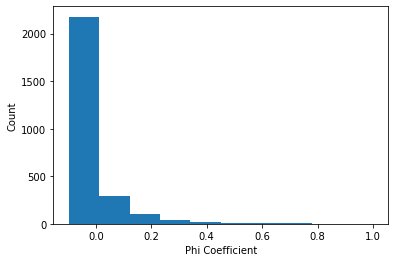

In [40]:
plt.hist(corr_df.corr_val)
plt.xlabel('Phi Coefficient')
plt.ylabel('Count')
plt.show()

From this analysis we can see a few simple trends. `latitude` and `longitude` both tend to be missing together, which makes sense, while the next most correlated missing fields are track metadata regarding production (`producer` and `engineer`) and associated album information (`type` and `date_created`). Importantly, from our histogram we don't see a great many of our classification-related fields are highly correlated.

## Filtering To The Most Relevant Data

In order to perform our analysis, we can reduce to the specific columns we will need to perform our classification. Since we are primarily interested in the genre target classification for our first pass, we use this as a gate for inclusion of data points in our analysis.

### Genre Specification

We can inspect the genres tagged by the FMA. From the cross tables we can observe that the archive is unbalanced, with some genres having far more associated tracks than others. Here we focus on the three most abundand genres: Rock, Experimental, and Electronic.

In [9]:
genre_counts = tracks.track.genre_top.value_counts()
print(genre_counts)

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: genre_top, dtype: int64


We can also observe that only half of the tracks have a `genre_top` designation.

In [10]:
print(tracks.shape)
print(genre_counts.sum())

(106574, 52)
49598


On closer inspection we can find that many of the tracks missing a `genre_top` value are represented in the `genres` and `genres_all` field, which links back to the `genre` table (also provided by the FMA). In future analyses, we can return to this data and attempt to identify tracks which can be considered linked to our genres investigated.

In [11]:
no_genre = tracks[tracks.track.genre_top.isna()]
no_genre.track[['genre_top', 'genres','genres_all']]

,genre_top,genres,genres_all
track_id,,,
20,NaN,"[76, 103]","[17, 10, 76, 103]"
26,NaN,"[76, 103]","[17, 10, 76, 103]"
30,NaN,"[76, 103]","[17, 10, 76, 103]"
46,NaN,"[76, 103]","[17, 10, 76, 103]"
48,NaN,"[76, 103]","[17, 10, 76, 103]"
...,...,...,...
155276,NaN,"[15, 32, 38]","[32, 38, 15]"
155277,NaN,"[15, 32, 38]","[32, 38, 15]"
155278,NaN,"[42, 107]","[42, 107, 1235, 15]"


We isolate the tracks of the genres we are interested in. This will be our focus for classification.

In [12]:
genre_tracks = tracks[tracks.track.genre_top.isin(['Rock','Experimental','Electronic'])]
print(genre_tracks.track.genre_top.value_counts())

Rock            14182
Experimental    10608
Electronic       9372
Name: genre_top, dtype: int64


## Computed Audio Features

Since the features included from the librosa analysis are derived from a mathematical analysis, these features are complete in the data set with no missing values. These audio summary statistics will be a useful resource as we attempt to find a link between genre and song structure.